In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
import warnings

warnings.filterwarnings(action='ignore')

import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

### Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    batch = np.random.choice(files, size = batch_size)    
    
    batch_x = []
    batch_y = []
    
    for f in batch:
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = to_categorical(batch_y)

    yield (batch_x, batch_y)   

In [0]:
batch_size = 32 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [8]:
print (x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 2)


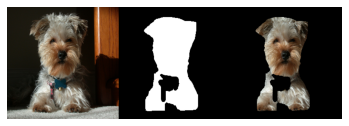

In [9]:
plt.axis('off')
img = x[0]
msk = y[0]
msk = msk[:,:,1]
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

### IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def block_residual(x, nKernels):
  identity = x
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  
  return x + identity

### Model

In [0]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  nKernels = 8
  layers = []

  encoding = Conv2D(nKernels, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (x) 

  layer11 = Conv2D(nKernels, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (encoding)
  layer11 = BatchNormalization()(layer11)
  layer11 = LeakyReLU()(layer11)

  layer12 = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same') (layer11)
  layer12 = layer12 + encoding
  layers.append(layer12)

  layer13 = MaxPooling2D() (layer12)
  layer13 = Conv2D(nKernels*2, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer13)

  layer21 = block_residual(layer13, nKernels*2)
  layers.append(layer21)
  layer21 = MaxPooling2D() (layer21)
  layer21 = Conv2D(nKernels*4, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer21)

  layer31 = block_residual(layer21, nKernels*4)
  layers.append(layer31)
  layer31 = MaxPooling2D() (layer31)
  layer31 = Conv2D(nKernels*8, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer31)

  layer41 = block_residual(layer31, nKernels*8)
  layers.append(layer41)
  layer41 = MaxPooling2D()(layer41)
  layer41 = Conv2D(nKernels*16, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer41)

  layer51 = block_residual(layer41, nKernels*16)
  layers.append(layer51)
  layer51 = MaxPooling2D()(layer51)
  layer51 = Conv2D(nKernels*32, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer51)

  layer61 = block_residual(layer51, nKernels*32)
  layers.append(layer61)
  layer61 = MaxPooling2D()(layer61)

  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer61)
  bottleneck11 = Dropout(0.2)(bottleneck11)
  bottleneck12 = Conv2D(nKernels*128, 3, activation='relu', kernel_initializer='he_normal', padding='same') (bottleneck11)
  bottleneck12 = Dropout(0.2)(bottleneck12)
  bottleneck13 = Conv2DTranspose(nKernels*64, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (bottleneck12)
  
  level = len(layers) - 1
  
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  layer71 = Conv2D(nKernels*64, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer71)
  layer71 = block_residual(layer71, nKernels*64)
  
  layer72 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer71)
  level = len(layers) - 2
  
  layer81 = Concatenate(axis=3)([layer72, layers[level]])
  layer81 = Conv2D(nKernels*32, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer81)
  layer81 = block_residual(layer81, nKernels*32)

  layer82 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer81)
    
  level = len(layers) - 3

  layer91 = Concatenate(axis=3)([layer82, layers[level]])
  layer91 = Conv2D(nKernels*16, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer91)
  layer91 = block_residual(layer91, nKernels*16)
  layer92 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (layer91)

  level = len(layers) - 4

  layer101 = Concatenate(axis=3)([layer92, layers[level]])
  layer101 = Conv2D(nKernels*8, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer101)
  layer101 = block_residual(layer101, nKernels*8)

  layer102 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer101)
  
  level = len(layers) - 5

  layer111 = Concatenate(axis=3)([layer102, layers[level]])
  layer111 = Conv2D(nKernels*4, 1, activation=None, use_bias=True, kernel_initializer='he_normal', padding='same') (layer111)
  layer111 = block_residual(layer111, nKernels*4)

  layer112 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer111)
  
  level = len(layers) - 6
  
  layer121 = Concatenate(axis=3)([layer112, layers[level]])
  
  classification1 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer121)
  classification1 = Dropout(0.25)(classification1)
  
  classification2 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (classification1)
  
  outputs = Conv2D(2, 1, activation='softmax') (classification2)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])
  
  return model

In [13]:
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1

        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        pred = model.predict(np.expand_dims(raw, 0))
               
        msk = np.argmax(pred, axis=-1)
        msk  = msk.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
  
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [15]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

print (train_steps, test_steps)

219 11


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
i= 1 loss= 0.9975529552594712 val_loss= 1.2308968630704014 mean_dsc= 0.55392003 val_mean_dsc= 0.51894146


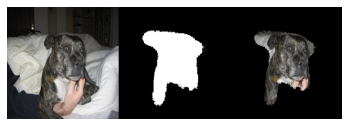

i= 2 loss= 0.5888126889864603 val_loss= 0.6150799718770114 mean_dsc= 0.7689478 val_mean_dsc= 0.76880187


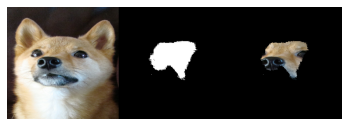

i= 3 loss= 0.47330338769851754 val_loss= 0.493559406562285 mean_dsc= 0.8176551 val_mean_dsc= 0.81374705


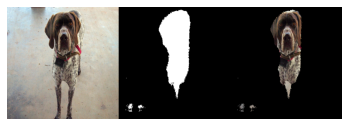

i= 4 loss= 0.4069638601993317 val_loss= 0.44082061539996753 mean_dsc= 0.84405094 val_mean_dsc= 0.84723973


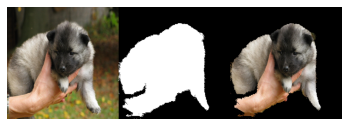

i= 5 loss= 0.35990449432368693 val_loss= 0.39137721061706543 mean_dsc= 0.8591864 val_mean_dsc= 0.8478331


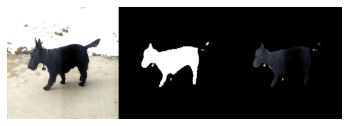

i= 6 loss= 0.32864289577693157 val_loss= 0.5012211176482114 mean_dsc= 0.87242997 val_mean_dsc= 0.80874354


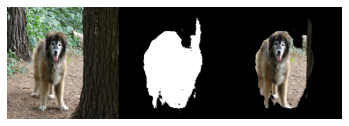

i= 7 loss= 0.3025169929140779 val_loss= 0.3868290131742304 mean_dsc= 0.8815894 val_mean_dsc= 0.8441214


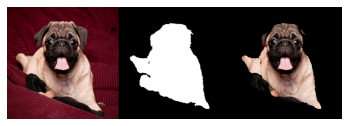

i= 8 loss= 0.279650796562025 val_loss= 0.35839232260530646 mean_dsc= 0.89063555 val_mean_dsc= 0.860988


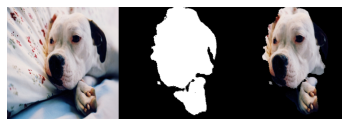

i= 9 loss= 0.26051208220388244 val_loss= 0.38058887828480115 mean_dsc= 0.89811414 val_mean_dsc= 0.8519287


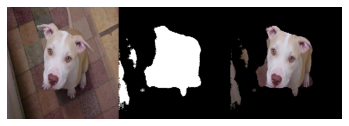

i= 10 loss= 0.2448499472173926 val_loss= 0.2791398777203126 mean_dsc= 0.90334666 val_mean_dsc= 0.892354


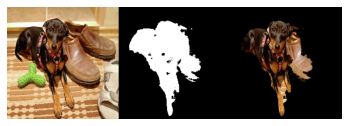

i= 11 loss= 0.232446697885043 val_loss= 0.34554297815669666 mean_dsc= 0.90842515 val_mean_dsc= 0.86294883


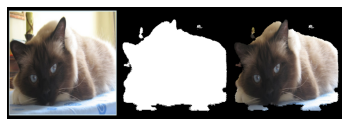

i= 12 loss= 0.22238250961314598 val_loss= 0.28562636267055164 mean_dsc= 0.9124557 val_mean_dsc= 0.8848326


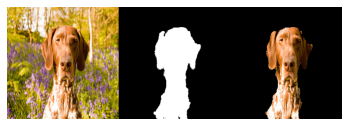

i= 13 loss= 0.21158056614333637 val_loss= 0.36814282969994977 mean_dsc= 0.9159716 val_mean_dsc= 0.8574993


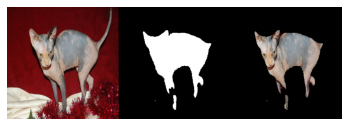

i= 14 loss= 0.20195741883423773 val_loss= 0.3476418067108501 mean_dsc= 0.92003584 val_mean_dsc= 0.8639008


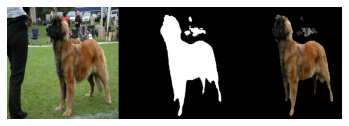

i= 15 loss= 0.19126004082699344 val_loss= 0.2884173474528573 mean_dsc= 0.9238721 val_mean_dsc= 0.8905583


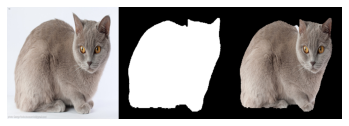

i= 16 loss= 0.1861734439248908 val_loss= 0.3003758435899561 mean_dsc= 0.9259135 val_mean_dsc= 0.8829123


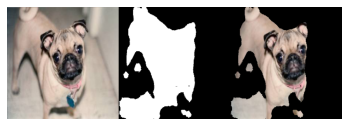

i= 17 loss= 0.18004663696844284 val_loss= 0.28339631990952924 mean_dsc= 0.9285221 val_mean_dsc= 0.8870987


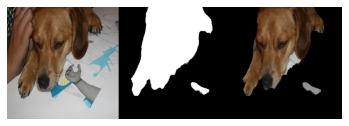

i= 18 loss= 0.17006601304768426 val_loss= 0.31291362372311676 mean_dsc= 0.93198663 val_mean_dsc= 0.87660944


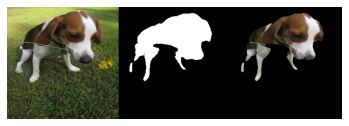

i= 19 loss= 0.16564363336454244 val_loss= 0.26475755734877154 mean_dsc= 0.9336143 val_mean_dsc= 0.8975449


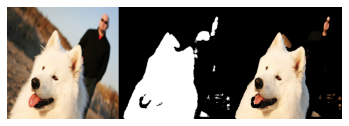

i= 20 loss= 0.15977151433354644 val_loss= 0.2728562747890299 mean_dsc= 0.9359542 val_mean_dsc= 0.8935814


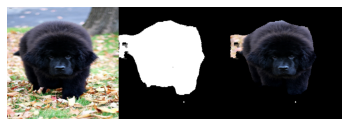

i= 21 loss= 0.15620647180298147 val_loss= 0.32660429586063733 mean_dsc= 0.93743986 val_mean_dsc= 0.8765503


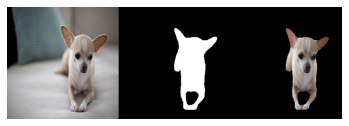

i= 22 loss= 0.15107431973768695 val_loss= 0.26338130777532404 mean_dsc= 0.9395524 val_mean_dsc= 0.89305156


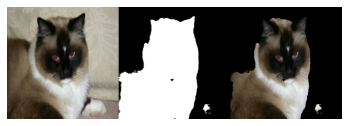

i= 23 loss= 0.14921089044036387 val_loss= 0.31616335294463416 mean_dsc= 0.9402664 val_mean_dsc= 0.88101715


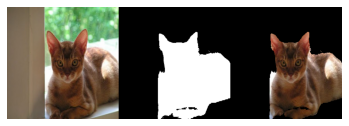

i= 24 loss= 0.14506854409496533 val_loss= 0.2900784245946191 mean_dsc= 0.9414788 val_mean_dsc= 0.88660425


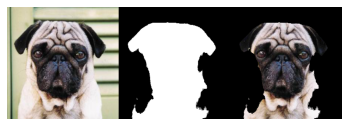

i= 25 loss= 0.14186327220642403 val_loss= 0.26372008432041516 mean_dsc= 0.94283265 val_mean_dsc= 0.8995895


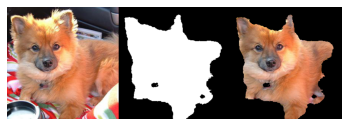

i= 26 loss= 0.13865955126339988 val_loss= 0.35873666676608 mean_dsc= 0.94399107 val_mean_dsc= 0.869204


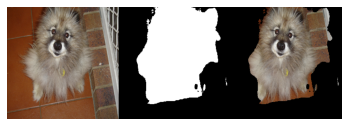

i= 27 loss= 0.13492247540520752 val_loss= 0.3161641305143183 mean_dsc= 0.9454263 val_mean_dsc= 0.87904716


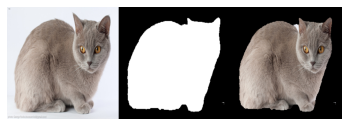

i= 28 loss= 0.13365981840107538 val_loss= 0.22644426334987988 mean_dsc= 0.94600934 val_mean_dsc= 0.9108795


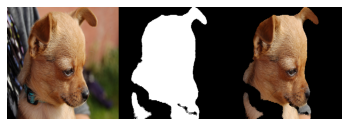

i= 29 loss= 0.12971548576197123 val_loss= 0.31121496991677716 mean_dsc= 0.94705063 val_mean_dsc= 0.8817112


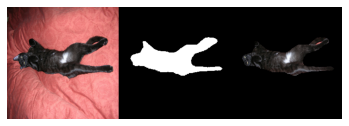

i= 30 loss= 0.12558961159562412 val_loss= 0.30171831223097717 mean_dsc= 0.9489521 val_mean_dsc= 0.8912448


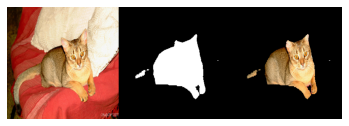

In [16]:
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [17]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-09 14:03:40--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.224.130.37, 13.224.130.112, 13.224.130.62, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.224.130.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.008s  

2020-05-09 14:03:40 (7.80 MB/s) - ‘test.jpg’ saved [63219/63219]



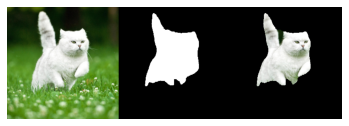

In [18]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

pred = model.predict(np.expand_dims(raw, 0))

msk = np.argmax(pred, axis=-1)
msk  = msk.squeeze()
msk = np.stack((msk,)*3, axis=-1)

combined = np.concatenate([raw, msk, raw* msk], axis = 1)

plt.axis('off')
plt.imshow(combined)
plt.show()